In [1]:
# automatically upload modules
%load_ext autoreload
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import re

import matplotlib.pyplot as plt
import numpy as np
import pickle
from ray import tune
import torch

from genome_embeddings import trainable # import before ray (?)
from genome_embeddings import pre_process
from genome_embeddings import corrupt
import ray

In [3]:
#from importlib import reload
import sys

In [4]:
#mode = "Desktop" 
mode = "CC"

# must change local_dir="/Users/natasha/Desktop/TUNE_RESULT_DIR"
# local_dir="/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_22-09-2020//TUNE_RESULT_DIR"

In [5]:
if mode == "Desktop":
    settings = Namespace(
        DATA_FP = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/data/', 
        SAVE_FP = '/Users/natasha/Desktop/',
        num_epochs = 2,
        num_cpus=5, 
        replacement_threshold = 0.5, # probability over which binarizer converts to a 1
        num_corruptions = 100, # number of corrupted versions of a genome to produce
    )
elif mode == "CC":
    settings = Namespace(
        DATA_FP = '/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_01-10-2020/',
        SAVE_FP = '/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_01-10-2020/',
        num_epochs = 2,
        num_cpus=5, 
        replacement_threshold = 0.5, # probability over which binarizer converts to a 1
        num_corruptions = 100, # number of corrupted versions of a genome to produce
    )
    

# Load data needed to make corrupted train + test datasets

In [6]:
create_new = False
from_scratch = False # controls where in creation process to jump in

# Create list of which genomes from KEGG to include in dataset
tla_to_tnum, keepers = pre_process.genomes2include()
org_to_kos, n_kos_tot, all_kos = pre_process.load_kos(tla_to_tnum)
org_to_mod_to_kos, mod_sets = pre_process.load_mods()

if create_new:
    if from_scratch:
        # Load list mods and KOs per genome
        data, genome_order = pre_process.make_tensor(org_to_mod_to_kos, org_to_kos, n_kos_tot, tla_to_tnum, all_kos)
        torch.save(data, "/Users/natasha/Desktop/kegg_v2.pt")
        torch.save(genome_order, "/Users/natasha/Desktop/genome_order.pt")
    else:
        # load data -- tensor (genomes + which KOs are encoded) + genome_order in tensor (tla)
        data = torch.load("/Users/natasha/Desktop/kegg_v2.pt")
        genome_order = torch.load("/Users/natasha/Desktop/genome_order.pt")
    
    # Create test-train split
    train_genomes, test_genomes = pre_process.train_test_split(keepers) # list of IDs to keep
    train_data = pre_process.prep_data(train_genomes, all_kos, org_to_kos, "train")
    test_data = pre_process.prep_data(test_genomes, all_kos, org_to_kos, "test")
    
    torch.save(org_to_mod_to_kos, "/Users/natasha/Desktop/all_kos_2020-09-29.pt")
    torch.save(org_to_mod_to_kos, "/Users/natasha/Desktop/org_to_mod_to_kos_2020-09-29.pt")
    torch.save(train_data, "/Users/natasha/Desktop/kegg_v2_train_2020-09-29.pt")
    torch.save(test_data, "/Users/natasha/Desktop/kegg_v2_test_2020-09-29.pt")
    torch.save(train_genomes, "/Users/natasha/Desktop/kegg_v2_train_genomes_2020-09-29.pt")
else:
    all_kos = torch.load("/Users/natasha/Desktop/all_kos_2020-09-29.pt")
    org_to_mod_to_kos = torch.load("/Users/natasha/Desktop/org_to_mod_to_kos_2020-09-29.pt")
    train_data = torch.load("/Users/natasha/Desktop/kegg_v2_train_2020-09-29.pt")
    test_data = torch.load("/Users/natasha/Desktop/kegg_v2_test_2020-09-29.pt")
    train_genomes = torch.load("/Users/natasha/Desktop/kegg_v2_train_genomes_2020-09-29.pt")
    test_genomes = torch.load("/Users/natasha/Desktop/kegg_v2_test_genomes_2020-09-29.pt")

mod_to_ko_clean = pre_process.clean_kos(mod_sets)

Total number of bacterial genomes in dataset: 2718
Total number of KOs in dataset: 9874


In [7]:
train_data.shape, test_data.shape

((2430, 9874), (288, 9874))

# Data exploration

In [ ]:
# mod = 'M00001'
# a = list(mod_sets[mod].values())
# a.sort(reverse=True)
# x_labels = [i for i in range(len(mod_sets[mod].values()))]
# plt.bar(x_labels, a)
# plt.yscale('log')
# plt.title("Variants of module "+mod)
# plt.xlabel("Variant (n="+str(len(mod_sets[mod].values()))+" )")
# plt.ylabel("Count across all genomes (n="+str(len(org_to_mod_to_kos))+")")
# print(max(mod_sets[mod].values()), len(a))

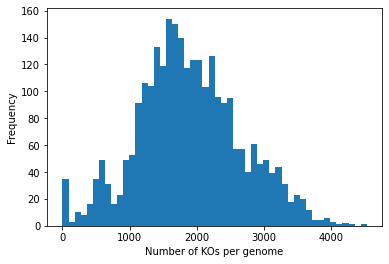

In [8]:
# Plot the number of KOs encoded by each genome
plt.hist([len(org_to_kos[i]) for i in org_to_kos], 50)
plt.xlabel("Number of KOs per genome")
plt.ylabel("Frequency")
plt.savefig("/Users/natasha/Desktop/fig.png")

In [ ]:
# # Plot the number of modules encoded by each genome
# n_genomes = len(org_to_mod_to_kos)
# temp = [list(org_to_mod_to_kos[i].keys()) for i in org_to_mod_to_kos]
# n_mods = len(list(set([item for sublist in temp for item in sublist])))
# plt.hist([len(org_to_mod_to_kos[i]) for i in org_to_mod_to_kos], 50)
# plt.xlabel("Number of modules per genome")
# plt.ylabel("Frequency")
# plt.title("Distribution of the # of modules (n="+str(n_mods)+") per genome (n="+str(n_genomes)+")")

In [ ]:
# a = [len(org_to_mod_to_kos[org]) for org in org_to_mod_to_kos]
# a.sort()
# print("There are "+str(a.count(0))+" genomes with zero modules")

# # Red
# # Rue
# # pvac
# # cgw

In [ ]:
# NOTE THAT SOME GENOMES DO NOT HAVE A SINGLE MOD AND AREN'T EVEN IN THE DICT (n= 2717-2713 = 5)
# E.G.: clap 

In [ ]:
# # Count and plot the number of genomes that encode each module
# mods_count = defaultdict(int)
# for org in org_to_mod_to_kos:
#     for mod in org_to_mod_to_kos[org]:
#         mods_count[mod] += 1
        
# plt.hist(mods_count.values(), 50)
# plt.xlabel("Number of genomes encoding each module")
# plt.ylabel("Frequency")
# plt.title("Distribution of the # of genomes (n="+str(n_genomes)+") encoding each module (n="+str(n_mods)+")")
# plt.yscale('log')
# print("Number of mods encoded in only one genome:",list(mods_count.values()).count(1))

In [ ]:
# DO NOT LET INPUT BE SUPER RARE MODS
# NN SHOULD JUST MEMORIZE THAT GENOME

In [ ]:
# # Plot the percentage of genes per genome that contribute to modules
# perc_mod = []
# for org in org_to_mod_to_kos:
#     try:
#         tla = tla_to_tnum[org]
#         n_kos = len(org_to_kos[tla])
#         n_mod_kos = len([org_to_mod_to_kos[org][mod] for mod in org_to_mod_to_kos[org]])
#         perc_mod.append(n_mod_kos/n_kos*100)
#     except: KeyError

# plt.hist(perc_mod, 50)
# plt.xlabel("Percent of KOs contributing to modules")
# plt.ylabel("Frequency")
# plt.title("Distribution of the % of KOs (n_all="+str(n_kos_tot)+") represented by modules (n="+str(n_mods)+") per genome (n="+str(n_genomes)+")")


In [ ]:
# # Percentage of KOs that are / are not part of a module

# kos_in_mods = []

# for org in org_to_mod_to_kos:
#     for mod in org_to_mod_to_kos[org]:
#         kos_in_mods.extend(org_to_mod_to_kos[org][mod])

# kos_in_mods = list(set(kos_in_mods))

# print(len(kos_in_mods), len(all_kos), len(kos_in_mods)/len(all_kos)*100)

In [ ]:
# # Number of KOs that are part of 1 module, 2 modules, 3 modules, etc
# #all_kos # unique list of all KOs
# ko_counter = defaultdict(list)

# for ko in all_kos:
#     for org in org_to_mod_to_kos:
#         for mod in org_to_mod_to_kos[org]:
#             if ko in org_to_mod_to_kos[org][mod]:
#                 if mod not in ko_counter[ko]:
#                     ko_counter[ko].append(mod)

In [ ]:
# ko_counter2 = {}
# for ko in ko_counter:
#     ko_counter2[ko] = len(ko_counter[ko])

# for ko in all_kos:
#     if ko not in ko_counter2:
#         ko_counter2[ko] = 0

In [ ]:
# a = defaultdict(int)
# for i in ko_counter2.values():
#     a[i] += 1
# a, sum(a.values())

In [ ]:
# plt.hist(ko_counter2.values())
# plt.yscale('log')
# plt.title("Number of modules each KO contributes to")
# plt.xlabel("Number of modules")
# plt.ylabel("Frequency (# of KOs)")

# New corruption process

In [11]:
# Remove any genomes with fewer than 500 KOs 
# Esp. important to remove genomes with 0 KOs (n=35)

good_idx_train = train_data.sum(axis=1) > 500
good_idx_test = test_data.sum(axis=1) > 500
train_data = train_data[good_idx_train,:]
test_data = test_data[good_idx_test,:]

# to numpy for indexing, then back to list for using
train_genomes = list(np.array(train_genomes)[good_idx_train])
test_genomes = list(np.array(test_genomes)[good_idx_train])

In [15]:
# Remove columns of all zeros in training set from train + test
good_idx_train = train_data.sum(axis=0) > 0
train_data = train_data[:,good_idx_train]
test_data = test_data[:,good_idx_train]

In [18]:
(train_data.sum(axis=1) == 0).sum(), (train_data.sum(axis=0) == 0).sum()

(0, 0)

In [21]:
(test_data.sum(axis=1) == 0).sum(), (test_data.sum(axis=0) == 0).sum()

(0, 1595)

In [22]:
# original version of corrupt used with DAE (pre-DVAE)

new_corrupt = False

if new_corrupt:
    corrupted_train, train_genome_idx = corrupt.corrupt_orig(train_data, settings.num_corruptions, 0.5)
    corrupted_test, test_genome_idx = corrupt.corrupt_orig(test_data, settings.num_corruptions, 0.5)
    torch.save(corrupted_train, "/Users/natasha/Desktop/corruptedv0_train_2020-10-02.pt")
    torch.save(corrupted_test, "/Users/natasha/Desktop/corruptedv0_test_2020-10-02.pt")
    torch.save(train_genome_idx, "/Users/natasha/Desktop/corruptedv0_train_genome_idx_2020-10-02.pt")
    torch.save(test_genome_idx, "/Users/natasha/Desktop/corruptedv0_test_genome_idx_2020-10-02.pt")
else:
    corrupted_train = torch.load("/Users/natasha/Desktop/corruptedv0_train_2020-10-02.pt")
    corrupted_test = torch.load("/Users/natasha/Desktop/corruptedv0_test_2020-10-02.pt")
    train_genome_idx = torch.load("/Users/natasha/Desktop/corruptedv0_train_genome_idx_2020-10-02.pt")
    test_genome_idx = torch.load("/Users/natasha/Desktop/corruptedv0_test_genome_idx_2020-10-02.pt")

In [ ]:
# # corrupt version 1 -- extreme corruption
# new_corrupt = True

# if new_corrupt:
#     tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}
#     corrupted_train, c_train_genomes = corrupt.corrupt(train_data, train_genomes, settings.num_corruptions, tnum_to_tla, "v1")
#     corrupted_test, c_test_genomes = corrupt.corrupt(test_data, test_genomes, settings.num_corruptions, tnum_to_tla, "v1")
#     torch.save(corrupted_train, "/Users/natasha/Desktop/corrupted_train_2020-09-04.pt")
#     torch.save(c_train_genomes, "/Users/natasha/Desktop/c_train_genomes_2020-09-04.pt")
#     torch.save(corrupted_test, "/Users/natasha/Desktop/corrupted_test_2020-09-04.pt.pt")
#     torch.save(c_test_genomes, "/Users/natasha/Desktop/c_test_genomes_2020-09-04.pt")
# else:
#     corrupted_train = torch.load("/Users/natasha/Desktop/corrupted_train_2020-09-04.pt")
#     c_train_genomes = torch.load("/Users/natasha/Desktop/c_train_genomes_2020-09-04.pt")
#     corrupted_test = torch.load("/Users/natasha/Desktop/corrupted_test_2020-09-04.pt")
#     c_test_genomes = torch.load("/Users/natasha/Desktop/c_test_genomes_2020-09-04.pt")
    

In [ ]:
# # Corrupt version 2
# # For each genome, remove only one KO 
# new_corrupt = False

# if new_corrupt:
#     tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}
#     corrupted_train, c_train_genomes = corrupt.corrupt(train_data, train_genomes, settings.num_corruptions, tnum_to_tla, org_to_mod_to_kos, all_kos, mod_to_ko_clean, "v2")
#     corrupted_test, c_test_genomes = corrupt.corrupt(test_data, test_genomes, settings.num_corruptions, tnum_to_tla, org_to_mod_to_kos, all_kos, mod_to_ko_clean,"v2")
#     torch.save(corrupted_train, "/Users/natasha/Desktop/corruptedv2_train_2020-09-30.pt")
#     torch.save(corrupted_train, "/Users/natasha/Desktop/c_train_genomesv2_train_2020-09-30.pt")
#     torch.save(corrupted_test, "/Users/natasha/Desktop/corruptedv2_test_2020-09-30.pt")
#     torch.save(corrupted_train, "/Users/natasha/Desktop/c_test_genomesv2_train_2020-09-30.pt")
# else:
#     corrupted_train = torch.load("/Users/natasha/Desktop/corruptedv2_train_2020-09-30.pt")
#     c_train_genomes = torch.load("/Users/natasha/Desktop/c_train_genomesv2_train_2020-09-30.pt")
#     corrupted_test = torch.load("/Users/natasha/Desktop/corruptedv2_test_2020-09-30.pt")
#     c_test_genomes = torch.load("/Users/natasha/Desktop/c_test_genomesv2_train_2020-09-30.pt")
   

In [ ]:
# # corrupt version 3
# new_corrupt = True

# if new_corrupt:
#     tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}
#     corrupted_train, c_train_genomes = corrupt.corrupt(train_data, train_genomes, settings.num_corruptions, tnum_to_tla, org_to_mod_to_kos, all_kos, mod_to_ko_clean, "v3")
#     corrupted_test, c_test_genomes = corrupt.corrupt(test_data, test_genomes, settings.num_corruptions, tnum_to_tla, org_to_mod_to_kos, all_kos, mod_to_ko_clean,"v3")
#     torch.save(corrupted_train, "/Users/natasha/Desktop/corruptedv3_train_2020-10-01.pt")
#     torch.save(corrupted_train, "/Users/natasha/Desktop/c_train_genomesv3_train_2020-10-01.pt")
#     torch.save(corrupted_test, "/Users/natasha/Desktop/corruptedv3_test_2020-10-01.pt")
#     torch.save(corrupted_train, "/Users/natasha/Desktop/c_test_genomesv3_train_2020-10-01.pt")
# else:
#     corrupted_train = torch.load("/Users/natasha/Desktop/corruptedv3_train_2020-10-01.pt")
#     c_train_genomes = torch.load("/Users/natasha/Desktop/c_train_genomesv3_train_2020-10-01.pt")
#     corrupted_test = torch.load("/Users/natasha/Desktop/corruptedv3_test_2020-10-01.pt")
#     c_test_genomes = torch.load("/Users/natasha/Desktop/c_test_genomesv3_train_2020-10-01.pt")
   

# Make sure there are no all-zero rows
### Note that this will mess up dictionaries mapping rows back to genome IDs

In [23]:
corrupted_train.shape, corrupted_test.shape

(torch.Size([233200, 19582]), torch.Size([28200, 19582]))

# Define and train network

In [ ]:
memory = 2000 * 1024 * 1024
object_store_memory = 200 * 1024 * 1024
driver_object_store_memory=100 * 1024 * 1024
ray.shutdown()
ray.init(local_mode=True, memory=memory, 
        object_store_memory=object_store_memory,
        driver_object_store_memory=driver_object_store_memory,
        num_cpus=10)

In [ ]:
config = {"num_epochs": 10,
         "kfolds": 10,
         "replacement_threshold": settings.replacement_threshold,
         "nn_layers": tune.choice([1, 2, 3, 4]),
         "batch_size": tune.choice([32, 64, 128, 256]),
          "lr": tune.loguniform(1e-4, 1e-1), 
          "weight_decay": tune.loguniform(1e-5, 1e-2) 
         }

In [ ]:
analysis = tune.run(
    trainable.train_AE, 
    name="sept_22_vae",
    config=config,
    verbose=2, 
    resources_per_trial={
            "cpu": 10,
            "gpu": 0
    },
    num_samples=20,  
    queue_trials=True,
    #local_dir="/Users/natasha/Desktop/TUNE_RESULT_DIR",
    local_dir="/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_01-10-2020/TUNE_RESULT_DIR"
    )

In [ ]:
print("Best config is:", analysis.get_best_config(metric="test_f1"))

In [ ]:
analysis.get_best_config(metric="test_f1")

# Evaluate model performance

In [ ]:
trainable.train_single_dae(3, 0.01, 0.001, 128, 10, 10, 0.5)

In [27]:
kld0, bce0, train_losses, test_losses, train_f1s, test_f1s, model = trainable.train_single_vae(3, 0.1, 0.001, 128, 10, 3, 0.5)
torch.save(model.state_dict(), "/Users/natasha/Desktop/model.pt")

[autoreload of genome_embeddings.trainable failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/usr/local/lib/python3.7/site-packages/torch/tensor.py", line 28, in wrapped
    return f(*args, **kwargs)
RuntimeError: The size of tensor a (19748) must match the size of tensor b (19582) at non-singleton dimension 1
]


11:32
num_features2 9791
epoch 0 batch 0
train_loss 887310.9375 train_f1 0.22550997620802118 test_loss 5965897.5 test_f1 0.36686454691408454
epoch 0 batch 100
train_loss 187179.8125 train_f1 0.7777988703988464 test_loss 1442406.875 test_f1 0.780422208566882
epoch 0 batch 200
train_loss 157275.578125 train_f1 0.8201746661090893 test_loss 1261118.875 test_f1 0.814280119931615
epoch 0 batch 300
train_loss 149088.28125 train_f1 0.8241856247644594 test_loss 363642.625 test_f1 0.8380199066317788
epoch 0 batch 400
train_loss 144524.8125 train_f1 0.8410483279168254 test_loss 1076725.375 test_f1 0.8498762076846295
epoch 0 batch 500
train_loss 131867.875 train_f1 0.8586289453964104 test_loss 1002286.0 test_f1 0.8601139605976619
epoch 0 batch 600
train_loss 125293.265625 train_f1 0.8714959995815142 test_loss 967742.625 test_f1 0.8672274562213732
epoch 0 batch 700
train_loss 113229.5625 train_f1 0.8782403202612845 test_loss 897890.375 test_f1 0.8770523107523018
epoch 0 batch 800
train_loss 113916.

In [ ]:
load_model = False
if load_model:
    from genome_embeddings import models
    n_features = int(corrupted_train.shape[1]/2)
    model = models.VariationalAutoEncoder(n_features, 3)
    model.load_state_dict(torch.load("/Users/natasha/Desktop/model.pt"))
    model.eval()

In [28]:
x = [i for i in range(len(kld0))]
kld0 = [int(i) for i in kld0]
bce0 = [int(i) for i in bce0]
# plt.scatter(x, kld0)
# plt.xlabel("Experience (batch)")
# plt.ylabel("KL Divergence")

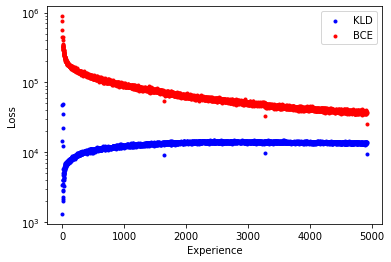

In [29]:
plt.scatter(x,kld0, c='b', marker='.', label='KLD')
plt.scatter(x,bce0, c='r', marker='.', label='BCE')
plt.legend(loc='upper right')
plt.xlabel("Experience")
plt.ylabel("Loss")
plt.yscale('log')
plt.savefig("/Users/natasha/Desktop/fig2.png")
plt.show()

In [30]:
from genome_embeddings import data_viz

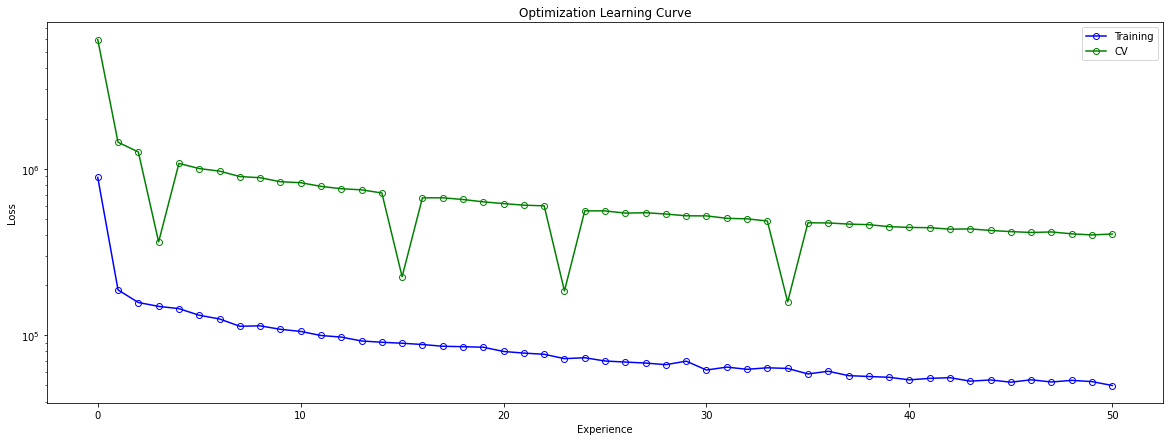

In [31]:
fig = data_viz.learning_curve(train_losses, test_losses, "optimization", False)

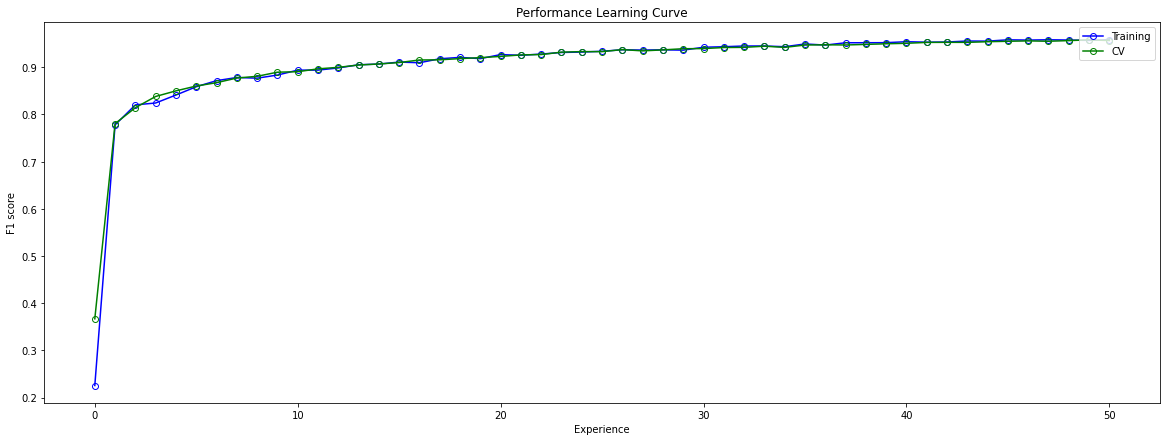

In [32]:
fig = data_viz.learning_curve(train_f1s, test_f1s, "performance", False)

In [33]:
import matplotlib.pyplot as plt

In [34]:
def genome_heatmap(corrupted_train, idx):
    n_features = int(corrupted_train.shape[1]/2)
    n_extension = 100*100 - n_features
    genome_rectangle1 = corrupted_train[idx][:n_features].tolist()
    genome_rectangle1.extend([2] * n_extension) # 100*100 - n_features
    genome_rectangle1 = np.reshape(genome_rectangle1, (100, 100))

    genome_rectangle2 = corrupted_train[idx][n_features:].tolist()
    genome_rectangle2.extend([2] * n_extension) # 100*100 - n_features
    genome_rectangle2 = np.reshape(genome_rectangle2, (100, 100))   

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(genome_rectangle2, cmap='hot', interpolation='nearest')
    ax2.imshow(genome_rectangle1, cmap='hot', interpolation='nearest')
    ax1.set_title("Uncorrupt")
    ax2.set_title("Corrupt")

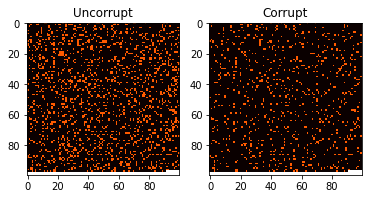

In [35]:
genome_heatmap(corrupted_train, 60000)

In [36]:
def genome_heatmap2(corrupted_test, idx):
    from matplotlib.colors import LinearSegmentedColormap
    import sklearn as sk
    #colours = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # R -> G -> B
    colours = ['black', 'green', 'orange', 'yellow', 'white']
    cmap_name = 'my_list'
    
    n_features = int(corrupted_test.shape[1]/2)
    n_extension = 100*100 - n_features
    
    # Get corrupted version of genome
    corrupted = corrupted_test[idx][:n_features].tolist()
    corrupted.extend([4] * n_extension) # 100*100 - n_features
    corrupted = np.reshape(corrupted, (100, 100))
    cm = LinearSegmentedColormap.from_list(cmap_name, colours, N=len(colours))
    # Get uncorrupted version of genome
    uncorrupted = corrupted_test[idx][n_features:].tolist()
    uncorrupted.extend([4] * n_extension) # 100*100 - n_features
    uncorrupted = np.reshape(uncorrupted, (100, 100))  
    
    # Get predicted uncorrupted version of genome
    corr_genome = corrupted_test[idx][:n_features]
    true_genome = corrupted_test[idx][n_features:]
    model.eval()
    pred = model.forward(corr_genome)
    pred = pred[0].tolist()
    binary_pred = [1 if i > 0.5 else 0 for i in pred]
    
    
    tn, fp, fn, tp = sk.metrics.confusion_matrix(true_genome, binary_pred).flatten()
    print("tn",tn, "fp",fp, "fn",fn, "tp",tp)
    
    colour_pred = []
    for i in zip(binary_pred, corr_genome, true_genome):
        if i[0] == i[2] == 1: # TP
            colour_pred.append(1) 
        elif i[0] == i[2] == 0: # TN
            colour_pred.append(0) 
        elif i[0] == 0 and i[2] == 1: # False negative
            colour_pred.append(2)
        else: # False positive
            colour_pred.append(3)
            
    print(len(colour_pred))
    print("n_features",n_features,"len(colour_pred)",len(colour_pred),"n_extension",n_extension)
    colour_pred.extend([4] * n_extension) # 100*100 - n_features
    print(len(colour_pred))
    colour_pred = np.reshape(colour_pred, (100, 100))  

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.imshow(uncorrupted, cmap=cm, interpolation='nearest')
    ax2.imshow(corrupted, cmap=cm, interpolation='nearest')  
    ax3.imshow(colour_pred, cmap=cm, interpolation='nearest')
    ax1.set_title("Uncorrupt")
    ax2.set_title("Corrupt")
    ax3.set_title("Predicted")
    return fig

tn 7734 fp 150 fn 169 tp 1738
9791
n_features 9791 len(colour_pred) 9791 n_extension 209
10000


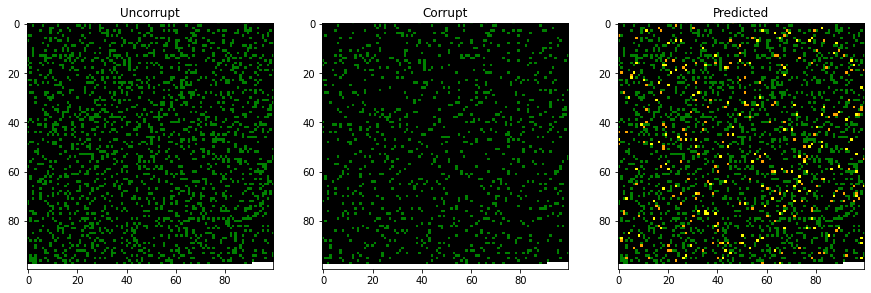

In [37]:
fig = genome_heatmap2(corrupted_test, 0)
fig.savefig("/Users/natasha/Desktop/fig4.png", bbox_inches='tight', dpi=200)

In [38]:
# Get predicted uncorrupted version of genome
n_features = int(corrupted_test.shape[1]/2)
corr_genome = corrupted_test[:,:n_features]
true_genome = corrupted_test[:,n_features:]
model.eval()
pred = model.forward(corr_genome)
#binary_preds = torch.zeros([true_genome.shape[0], true_genome.shape[1]])
binary_preds = trainable.binarize(pred[0], 0.5)

In [39]:
np.min(np.isnan(pred[0].detach().numpy()))

False

In [40]:
np.max(np.isnan(binary_preds))

False

In [41]:
type(binary_preds)

list

In [43]:
from sklearn.metrics import roc_auc_score
num_features = int(corrupted_test.shape[1]/2)
true_genomes = corrupted_test[:,num_features:]
print(num_features, true_genomes.shape)

9791 torch.Size([28200, 9791])


In [45]:
true_genomes.shape, pred[0].shape

(torch.Size([28200, 9791]), torch.Size([28200, 9791]))

In [46]:
data_viz.my_roc_curve(true_genomes.numpy(), pred[0].detach().numpy())

num 1s 1000.0
num 0s 8791.0
sum 1s and 0s 9791
target[:, i] False
y_probas[:, i] False
num 1s 15500.0
num 0s -5709.0
sum 1s and 0s 9791
target[:, i] False
y_probas[:, i] False
num 1s 1400.0
num 0s 8391.0
sum 1s and 0s 9791
target[:, i] False
y_probas[:, i] False
num 1s 5500.0
num 0s 4291.0
sum 1s and 0s 9791
target[:, i] False
y_probas[:, i] False
num 1s 8600.0
num 0s 1191.0
sum 1s and 0s 9791
target[:, i] False
y_probas[:, i] False
num 1s 1300.0
num 0s 8491.0
sum 1s and 0s 9791
target[:, i] False
y_probas[:, i] False
num 1s 0.0
num 0s 9791.0
sum 1s and 0s 9791
target[:, i] False
y_probas[:, i] False
num 1s 9800.0
num 0s -9.0
sum 1s and 0s 9791
target[:, i] False
y_probas[:, i] False
num 1s 1900.0
num 0s 7891.0
sum 1s and 0s 9791
target[:, i] False
y_probas[:, i] False
num 1s 800.0
num 0s 8991.0
sum 1s and 0s 9791
target[:, i] False
y_probas[:, i] False
num 1s 200.0
num 0s 9591.0
sum 1s and 0s 9791
target[:, i] False
y_probas[:, i] False
num 1s 8900.0
num 0s 891.0
sum 1s and 0s 9791
ta

FloatingPointError: invalid value encountered in less

In [ ]:
#a = np.array([i.tolist() for i in binary_preds])

In [ ]:
#a[0]

In [ ]:
#true_genomes.numpy()

In [ ]:
type(pred[3])